In [53]:
import numpy as np
import os
from os.path import isfile

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers

import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

### Training and Validation Data Sets Load

#### Define global paths

In [54]:
DATA_DIR = '/Users/james/Documents/Data/genre classification/' 
AUDIO_DIR = DATA_DIR + 'Audio' 
NPZ_DIR = DATA_DIR + 'npz'

In [55]:
# folder to save model results
if not os.path.exists('./models/crnn'):
    os.makedirs('./models/crnn')

#### load

In [56]:
npzfile = np.load(NPZ_DIR + '/shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(2024, 640, 128) (2024, 2)


In [57]:
npzfile = np.load(NPZ_DIR + '/shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(579, 640, 128) (579, 2)


#### genre look-up (based off of genre_target variable in data_transformer

In [58]:
dict_genre_targets = {'Club': 0, 'bass-other': 1}
reverse_genre_dict = {j:i for i, j in dict_genre_targets.items()}
print(reverse_genre_dict)

{0: 'Club', 1: 'bass-other'}


#### Spectrogram Checks

In [60]:
example_track_num = 1000
spectogram = X_train[example_track_num]
genre = np.argmax(y_train[example_track_num])
print(genre)
print(reverse_genre_dict[genre])

1
bass-other


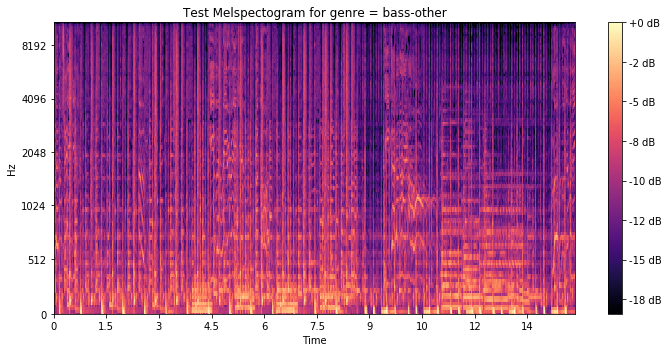

In [63]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram for genre = ' + reverse_genre_dict[genre])
plt.tight_layout()

### CNN-RNN Serial Model

In [67]:
batch_size = 32
num_classes = len(np.unique(y_train))
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [68]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes)(layer)
    layer = Activation('softmax', name='output_realtime')(layer)
    model_output = layer
    model = Model(model_input, model_output)
    
    opt = Adam(lr=0.001)
    model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [69]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    #y_train = np_utils.to_categorical(y_train, num_classes) 
    #y_val   = np_utils.to_categorical(y_val, num_classes) 
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [70]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [71]:
# run
model, history = train_model(X_train, y_train, X_valid, y_valid)

Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128)         0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 56)          224       
_________________________________________________________________
activation_10 (Activation)   (None, None, 56)          0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, None, 56)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None, 56)          157


Epoch 00025: val_acc improved from 0.71330 to 0.73402, saving model to ./models/crnn/weights.best.h5
Epoch 26/70
2024/2024 [==============================] - 9s 4ms/step - loss: 0.6412 - acc: 0.7273 - val_loss: 0.7027 - val_acc: 0.7133

Epoch 00026: val_acc did not improve from 0.73402
Epoch 27/70
2024/2024 [==============================] - 9s 4ms/step - loss: 0.6059 - acc: 0.7658 - val_loss: 0.5948 - val_acc: 0.7461

Epoch 00027: val_acc improved from 0.73402 to 0.74611, saving model to ./models/crnn/weights.best.h5
Epoch 28/70
2024/2024 [==============================] - 9s 4ms/step - loss: 0.6021 - acc: 0.7599 - val_loss: 0.6570 - val_acc: 0.7012

Epoch 00028: val_acc did not improve from 0.74611
Epoch 29/70
2024/2024 [==============================] - 9s 4ms/step - loss: 0.6063 - acc: 0.7495 - val_loss: 0.9658 - val_acc: 0.5354

Epoch 00029: val_acc did not improve from 0.74611
Epoch 30/70
2024/2024 [==============================] - 9s 4ms/step - loss: 0.6024 - acc: 0.7564 - val

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


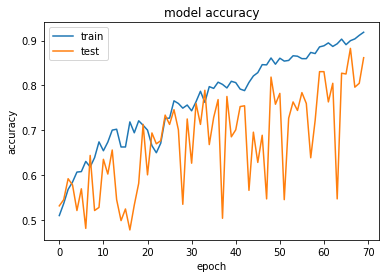

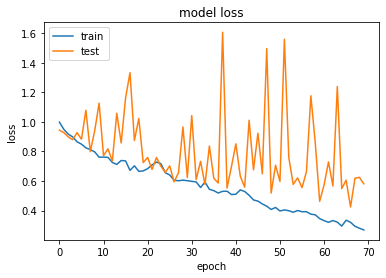

In [72]:
show_summary_stats(history)

In [98]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)
target_names = reverse_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(579,) (579,)
              precision    recall  f1-score   support

        Club       0.83      0.92      0.87       302
  bass-other       0.90      0.80      0.85       277

    accuracy                           0.86       579
   macro avg       0.87      0.86      0.86       579
weighted avg       0.87      0.86      0.86       579



In [99]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.8618307426597582


### Test

In [112]:
from keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

In [113]:
npzfile = np.load(NPZ_DIR + '/test_array.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(289, 640, 128) (289, 2)


In [114]:
# scale
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0 0.003061754925876369


In [115]:
X_test = np.log(X_test_raw)

In [116]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
target_names = reverse_genre_dict.values()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(289,) (289,)
              precision    recall  f1-score   support

        Club       0.79      0.90      0.84       133
  bass-other       0.91      0.79      0.85       156

    accuracy                           0.84       289
   macro avg       0.85      0.85      0.84       289
weighted avg       0.85      0.84      0.84       289



In [117]:
model.evaluate(X_test, y_test)

289/289 [==============================] - 1s 3ms/step


[0.5896933276244926, 0.8442906574394463]

In [118]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=reverse_genre_dict.values(),
            yticklabels=reverse_genre_dict.values())
plt.xlabel('true label')
plt.ylabel('predicted label');

ModuleNotFoundError: No module named 'seaborn'